# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://platform.wbscodingschool.com/courses/data-science/9474/) and use what you've learnt to see how reliable the data is.

In [ ]:
import pandas as pd

Load our cleaned DataFrames

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 6)
#pd.set_option("large_repr", "truncate")
#pd.set_option("display.precision", 2)
#pd.set_option("colheader_justify", "right")
#pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)
#pd.set_option("display.html.table_schema", True)

## 2.&nbsp; Exclude unwanted orders

In [ ]:
orders = orders_cl
orderlines = orderlines_cl
products = products_cl

There are:
* Cancelled
* Completed
* Pending
* Shopping Basket
* Place Order

Company is making actual money from orders with the state: Completed

In [ ]:
completed_orders_df = orders[orders["state"] == "Completed"]

In [ ]:
ord_ordlin = completed_orders_df.merge(orderlines, how = "inner", left_on = "order_id", right_on = "id_order")

In [ ]:
orderlines_end_step_2 = orderlines.loc[orderlines.id_order.isin(ord_ordlin.id_order), :]
orders_end_step_2 = orders.loc[orders.order_id.isin(ord_ordlin.order_id), :]

## 3.&nbsp; Exclude orders with unknown products
## Version 1


In [ ]:
# Making copies
orderlines_df = orderlines_cl.copy()
completed_orders_df = orders_cl.copy()

# Excluding all orders except the ones that are completed
completed_orders_df = completed_orders_df.loc[completed_orders_df['state'].isin(['Completed']), :]

# Merging two df and keeping only orders that are present in both df
completed_orders_df = completed_orders_df.rename(columns={"order_id": "id_order"})
merged_df = completed_orders_df.merge(orderlines_df, how = 'inner', on = 'id_order')

In [ ]:
# products from orderlines that are non existing in products
unknown_products_df = merged_df.loc[~merged_df.sku.isin(products_cl.sku),:]

# deleting non existing products from orderlines
merged_df = merged_df.loc[~merged_df.sku.isin(unknown_products_df.sku),:]

# making a list of orders that should be deleted from both orderlines and orders
order_tobe_deleted = unknown_products_df['id_order'].tolist()

# excluding them from orders
merged_df = merged_df.loc[~merged_df.id_order.isin(order_tobe_deleted),:]

# deleting orders from orderlines
merged_df = merged_df.loc[~merged_df.id_order.isin(order_tobe_deleted),:]
merged_df["id_order"].nunique()


## Version 2

In [ ]:
unknown_products_df = orderlines_end_step_2.loc[~orderlines_end_step_2.sku.isin(products.sku),]

In [ ]:
unknown_products_df.head()

In [ ]:
unknown_order_id_list  = list(unknown_products_df.id_order)

In [ ]:
orders_end_step_3 = orders_end_step_2[~orders_end_step_2["order_id"].isin(unknown_order_id_list)]

In [ ]:
orderlines_end_step_3 = orderlines_end_step_2[~orderlines_end_step_2["id_order"].isin(unknown_order_id_list)]

In [ ]:
orders_end_step_3["order_id"].nunique(), orderlines_end_step_3["id_order"].nunique()

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_end_step_3_copy = orderlines_end_step_3.copy()

In [ ]:
orderlines_end_step_3_copy.loc[:, "unit_price_total"] = orderlines_end_step_3_copy.loc[:, "unit_price"] * orderlines_end_step_3_copy.loc[:, "product_quantity"]

In [ ]:
orderlines_end_step_3_copy.head()

#### Step 2: 
Group by `order_id`, summarising by the sum of `unit_price_total`

In [ ]:
unit_price_total_df = orderlines_end_step_3_copy.groupby("id_order").agg({"unit_price_total" : "sum"})

In [ ]:
unit_price_total_df.head()

### What is the average difference between `total_paid` and `unit_price_total`?

In [ ]:
#orders_end_step_3
unit_price_total_df

,unit_price_total
id_order,
241423,129.16
242832,10.77
243330,77.99
...,...
527074,19.98
527096,29.97
527112,9.99


In [ ]:
comparison_df = orders_end_step_3.merge(unit_price_total_df, how="inner", left_on="order_id", right_on="id_order")
comparison_df["diff_price"] = (comparison_df["total_paid"] - comparison_df["unit_price_total"])

In [ ]:
comparison_df.head()

,order_id,created_date,total_paid,state,unit_price_total,diff_price
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99


In [ ]:
comparison_df["diff_price"].mean()

4.474808277978945

### What is the distribution of these differences?

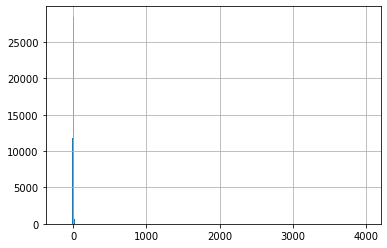

In [ ]:
comparison_df["diff_price"].hist(bins=500);

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

In [ ]:
comparison_df["diff_price"].describe()
# 50% of differences are less than 6 Euro those can be explained by shipping costs
# everything else could be explained by discounts or repricing, e.g. for new models 

count   41701.00
mean        4.47
std        26.05
          ...   
50%         4.99
75%         6.99
max      3984.99
Name: diff_price, Length: 8, dtype: float64

### If there are differences that you can’t explain: what should you do with these orders?

In [ ]:
# probably exclude them?! but it is a lot of orders with differences 

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

In [ ]:
# your thoughts & code here

Do not forget to download your quality controlled DataFrames

In [ ]:
from google.colab import files

orders_end_step_3.to_csv("orders_qu.csv", index=False)
files.download("orders_qu.csv")

orderlines_end_step_3_copy.to_csv("orderlines_qu.csv", index=False)
files.download("orderlines_qu.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>